<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import stopwords
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from tqdm import notebook
from sklearn.metrics import f1_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [ ]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [ ]:
df.duplicated().sum()


0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В данных отсутствуют пропуски и дубликаты. Можно переходить к лематизации данных.

Напишем ф-цию очистки текста от лишних символов и лемматизируем текст

In [ ]:
%time
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
import pandas as pd
import re
def clear_text(text):#Фунцкия очистки от лишних пробелов и символов
    x = re.sub(r'[^a-zA-Z]',' ',text).split()
    y =" ".join(x)
    return y

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemm_(text):

    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return lemmatized_output


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df['clear_text'] = df['text'].apply(clear_text)

df['lemmatized_text'] = df['clear_text'].apply(lemm_)

In [ ]:
df

,Unnamed: 0,text,toxic,clear_text,lemmatized_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,Explanation Why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww He match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I m really not trying to edit war It s...,Hey man I m really not try to edit war It s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,You sir are my hero Any chance you remember wh...,You sir be my hero Any chance you remember wha...
...,...,...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0,And for the second time of asking when your vi...,And for the second time of ask when your view ...
159288,159447,You should be ashamed of yourself \n\nThat is ...,0,You should be ashamed of yourself That is a ho...,You should be ashamed of yourself That be a ho...
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm theres no actual article for prost...,Spitzer Umm there no actual article for prosti...
159290,159449,And it looks like it was actually you who put ...,0,And it looks like it was actually you who put ...,And it look like it be actually you who put on...


Векторизируем наши признаки с учетом стоп-слов TF-IDF

In [ ]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
counr_tf_idf = TfidfVectorizer(stop_words=stopwords)
#tf_idf = counr_tf_idf.fit_transform(corpus)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Разделим выборку на trein,test

In [ ]:
features = df['lemmatized_text']
target = df['toxic']
features_train,features_test,target_train,target_test =train_test_split(features,target,test_size = 0.2,random_state = 12345)
#features_valid,features_test,target_valid,target_test= train_test_split(features_valid,target_valid,test_size = 0.5,random_state = 12345)

Получим TF-IDF векторы

In [ ]:
tf_idf_train = counr_tf_idf.fit_transform(features_train)
tf_idf_test = counr_tf_idf.transform(features_test)
#tf_idf_valid = counr_tf_idf.transform(features_valid)

In [ ]:
tf_idf_train.shape


(127433, 139430)

In [ ]:
tf_idf_test.shape

(31859, 139430)

<function matplotlib.pyplot.show(close=None, block=None)>

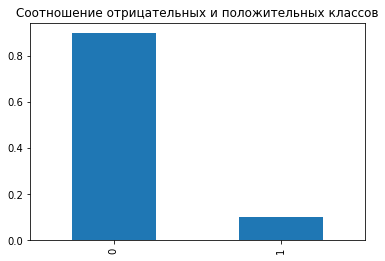

In [ ]:
class_frequency = df['toxic'].value_counts(normalize = True)
class_frequency.plot(kind = 'bar',title = 'Соотношение отрицательных и положительных классов')
plt.show

В данных виден дисбаланс классов, будем учитывать это в параметрах моделей.

***Данные были предварительно подготовлены к обучению:
-Разбили текст на токены
-Провели лемматизацию
-Векторизировали данные с учетом стоп слов***

## Обучение

*DecisionTreeClassifier*

In [ ]:
%%time
tree = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
GS_tree = GridSearchCV(estimator = tree,
                  param_grid = {'max_depth':[x for x in range(5, 30, 5)]},
                  scoring = ["f1"],
                  refit = "f1",
                  cv=3
                  )
GS_tree.fit(tf_idf_train, target_train)
print('Лучшие параметры модели:',GS_tree.best_params_)
print('F1:',GS_tree.best_score_)

Лучшие параметры модели: {'max_depth': 25}
F1: 0.6087416339653925
CPU times: user 3min 41s, sys: 714 ms, total: 3min 42s
Wall time: 3min 42s


Лучший показатель f1 = 0.59 у модели DecisionTreeClassifier,при гиперпараметрах max_depth = 25. Модель не дотягивает до нужного значения целевой метрики заказчика.

*RandomForestClassifier*

In [ ]:
%%time
parametrs = {'n_estimators': range (10, 51, 10),
            'max_depth': range (1,13, 2),}

tree = RandomForestClassifier(random_state=12345, class_weight='balanced')

GS_random = GridSearchCV(estimator = tree,param_grid = parametrs,scoring = "f1",cv=3)
GS_random.fit(tf_idf_train, target_train)
print('Лучшие параметры модели:',GS_random.best_params_)
print('F1:',GS_random.best_score_)

Лучшие параметры модели: {'max_depth': 11, 'n_estimators': 50}
F1: 0.35154562857652727
CPU times: user 4min 34s, sys: 3.12 s, total: 4min 37s
Wall time: 4min 38s


Лучший показатель f1 = 0.34 у модели RandomForestClassifier,при гиперпараметрах max_depth = 11,n_estimators= 50. Модель не дотягивает до нужного значения целевой метрики заказчика.

*LogisticRegression*

In [ ]:
%%time
pipe = Pipeline([
    ('model', LogisticRegression(random_state=1, solver='liblinear', max_iter=200))])


param_grid = [
        {

            'model': [LogisticRegression(random_state=42, solver='liblinear')],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(1,15,3))
        }
]
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=3, verbose=True, n_jobs=-1)
best_grid = grid.fit(tf_idf_train, target_train)
print('Best parameters is:', grid.best_params_)
print('Best score is:', grid.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters is: {'model': LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear'), 'model__C': 4, 'model__penalty': 'l1'}
Best score is: 0.7657137112040164
CPU times: user 1min 57s, sys: 1min 50s, total: 3min 47s
Wall time: 3min 48s


Лучший показатель f1 = 0.77 у модели LogisticRegression,при гиперпараметрах C=4, penalty='l1', random_state=42, solver='liblinear'. Модель подходит под значение целевой метрики.

*LGBMClassifier*

%%time
model_lgb = LGBMClassifier(class_weight='balanced')

params = {'max_depth':[1,3,5]}

gr_s = GridSearchCV(model_lgb, params, scoring='f1', cv=3)
gr_s.fit(tf_idf_train, target_train)

print('Best parameters is:',gr_s.best_params_)
print('Best score is:',gr_s.best_score_)

Лучший показатель f1 = 0.69 у модели LGBMClassifier. Модель не дотягивает до нужного значения целевой метрики заказчика.

In [ ]:
model = [['LGBMClassifier',0.69],
         ['LogisticRegression',0.77],
         ['RandomForestClassifier',0.34],
         ['DecisionTreeClassifier',0.59]]
columns = ['model','F1 score']
analysis_data = pd.DataFrame(data=model, columns=columns)
analysis_data

,model,F1 score
0,LGBMClassifier,0.69
1,LogisticRegression,0.77
2,RandomForestClassifier,0.34
3,DecisionTreeClassifier,0.59


***Лучший показатель у логистической регресси, проверим на значение метрики на тестовых данных***

In [ ]:
model_final = grid.best_estimator_
valid_pred_final = model_final.predict(tf_idf_test)
f1_score(target_test, valid_pred_final)

0.7801490514905149

***Целевая метрика F1 достигнута. Уровнень выше значения 0.75***

## Выводы

***Была проведена предварительная подготовка данных и обучено 4 модели.
Целевые показатели метрики F1 были достигнуты у модели логистической регрессии. Показатель метрики на тестовых данных = 0.78, что удовлетворяет требованиям заказчика.***